In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

sns.set(style="whitegrid")

In [2]:
# Load dataset
df = pd.read_csv("marketing_campaign.csv")

# Basic info
print(df.shape)
print(df.columns)
df.head()
df.info()
df.isnull().sum()

(9134, 24)
Index(['Customer', 'State', 'Customer Lifetime Value', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Income',
       'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size', 'Response'],
      dtype='str')
<class 'pandas.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   str    
 1   State                          9134 non-null   str    
 2   Customer Lifetime Value        9134 non-null   float64
 3   Coverage                       9134 non-null   str    
 4   Education                 

Customer                         0
State                            0
Customer Lifetime Value          0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
Response                         0
dtype: int64

In [3]:
# Copy for visualization
df_viz = df.copy()

# Keep Response as Yes/No for df_viz
# (so plots show Yes/No labels directly)
# No need to map to 0/1 here

In [4]:
# Preprocessing for modeling
df['Response'] = df['Response'].map({'No':0, 'Yes':1})
df.drop(['Customer','Effective To Date'], axis=1, inplace=True)

cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Response')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14252\653073610.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include='object').columns


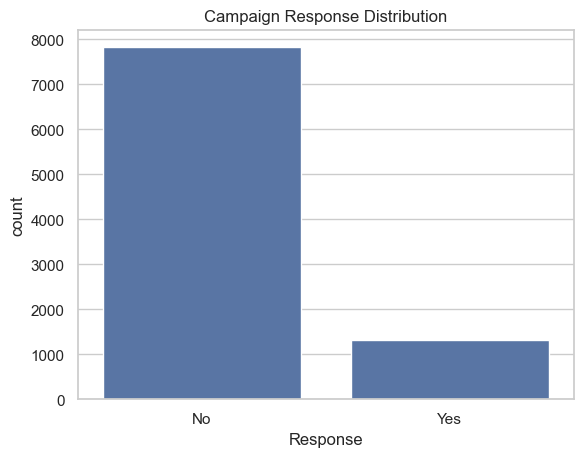

In [5]:
sns.countplot(x='Response', data=df_viz)
plt.title("Campaign Response Distribution")
plt.show()

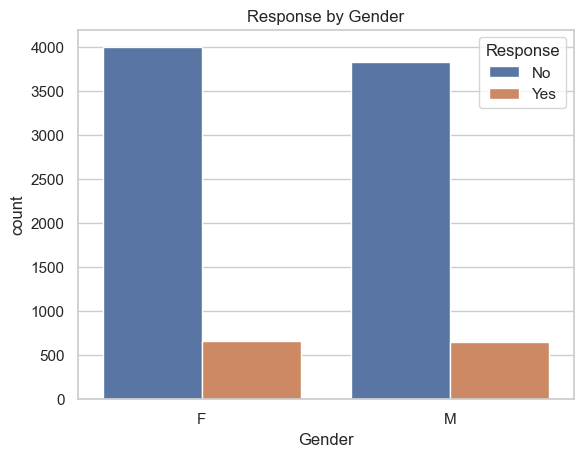

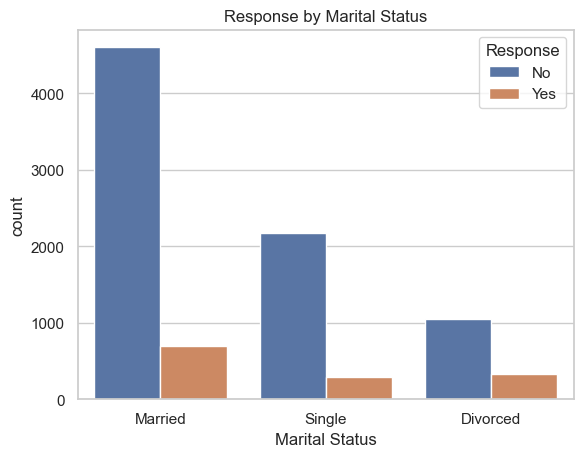

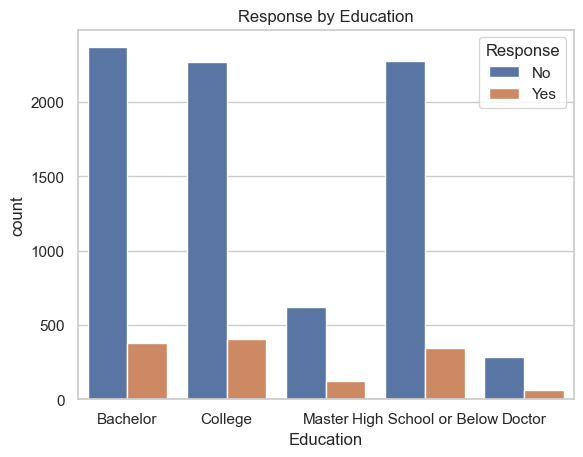

In [6]:
sns.countplot(x='Gender', hue='Response', data=df_viz)
plt.title("Response by Gender")
plt.show()

sns.countplot(x='Marital Status', hue='Response', data=df_viz)
plt.title("Response by Marital Status")
plt.show()

sns.countplot(x='Education', hue='Response', data=df_viz)
plt.title("Response by Education")
plt.show()

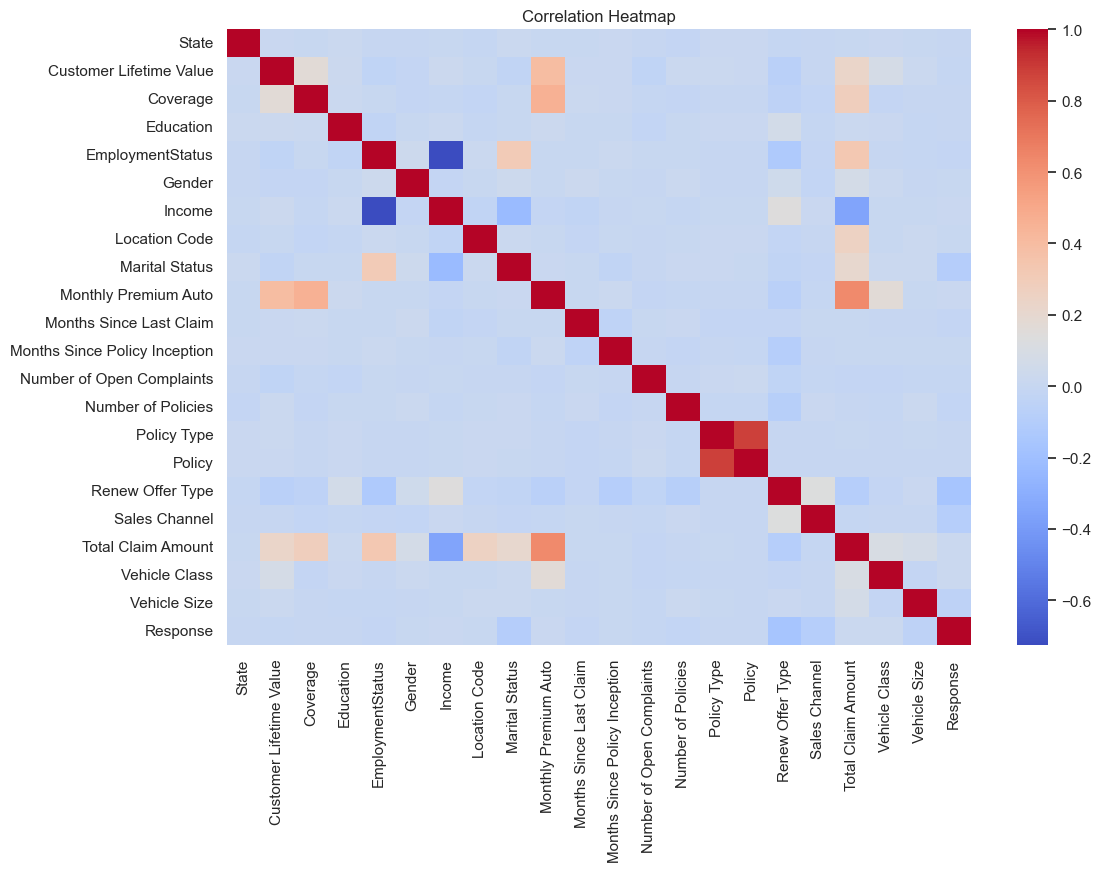

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [8]:
X_cluster = df[['Customer Lifetime Value',
                'Income',
                'Monthly Premium Auto',
                'Total Claim Amount']]

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

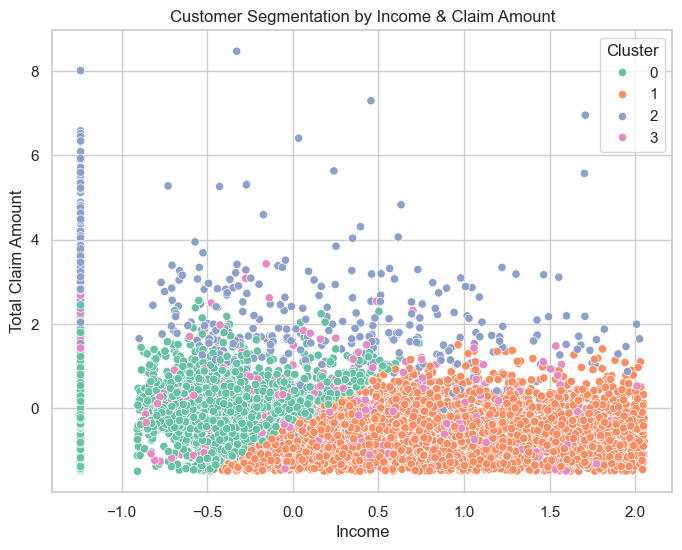

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='Total Claim Amount',
                hue='Cluster', data=df, palette="Set2")
plt.title("Customer Segmentation by Income & Claim Amount")
plt.show()

In [12]:
cluster_response = df.groupby('Cluster')['Response'].mean()
print(cluster_response)

Cluster
0    0.153191
1    0.137801
2    0.112054
3    0.136808
Name: Response, dtype: float64


In [13]:
X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Results (Balanced):")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1]))

Logistic Regression Results (Balanced):
              precision    recall  f1-score   support

           0       0.90      0.59      0.72      2332
           1       0.21      0.62      0.31       409

    accuracy                           0.60      2741
   macro avg       0.55      0.61      0.51      2741
weighted avg       0.80      0.60      0.66      2741

ROC-AUC: 0.6549526729210265


In [16]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [17]:
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2332
           1       0.99      0.97      0.98       409

    accuracy                           0.99      2741
   macro avg       0.99      0.98      0.99      2741
weighted avg       0.99      0.99      0.99      2741

ROC-AUC: 0.9996204607313155


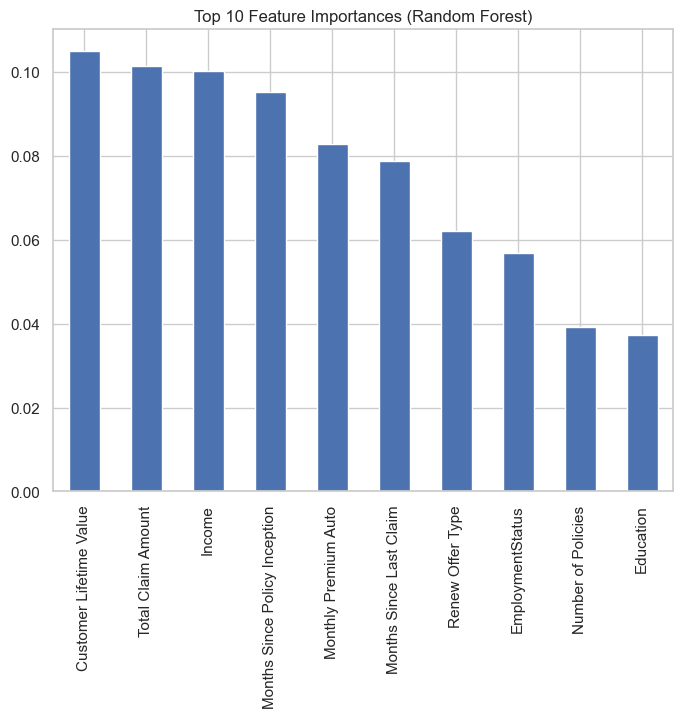

In [18]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(8,6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [19]:
offer_response = df_viz.groupby('Renew Offer Type')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(offer_response)

Response                No       Yes
Renew Offer Type                    
Offer1            0.841684  0.158316
Offer2            0.766234  0.233766
Offer3            0.979050  0.020950
Offer4            1.000000  0.000000


In [20]:
employment_response = df_viz.groupby('EmploymentStatus')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(employment_response)

Response                No       Yes
EmploymentStatus                    
Disabled          0.822222  0.177778
Employed          0.867322  0.132678
Medical Leave     0.819444  0.180556
Retired           0.276596  0.723404
Unemployed        0.914545  0.085455


In [21]:
education_response = df_viz.groupby('Education')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(education_response)

Response                    No       Yes
Education                               
Bachelor              0.862445  0.137555
College               0.847818  0.152182
Doctor                0.824561  0.175439
High School or Below  0.869565  0.130435
Master                0.838057  0.161943


In [24]:
df_viz_nonzero = df_viz[df_viz['Income'] > 0]
df_viz_nonzero['IncomeBand'] = pd.qcut(df_viz_nonzero['Income'], q=4, labels=['Low','Medium','High','Very High'])
income_response = df_viz_nonzero.groupby('IncomeBand')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(income_response)

Response          No       Yes
IncomeBand                    
Low         0.754098  0.245902
Medium      0.876543  0.123457
High        0.855634  0.144366
Very High   0.862676  0.137324


In [25]:
channel_response = df_viz.groupby('Sales Channel')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(channel_response)

Response             No       Yes
Sales Channel                    
Agent          0.808456  0.191544
Branch         0.885469  0.114531
Call Center    0.891218  0.108782
Web            0.882264  0.117736


In [26]:
policy_response = df_viz.groupby('Policy Type')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(policy_response)

Response              No       Yes
Policy Type                       
Corporate Auto  0.853659  0.146341
Personal Auto   0.858869  0.141131
Special Auto    0.835979  0.164021


In [27]:
vehicle_response = df_viz.groupby('Vehicle Size')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(vehicle_response)

Response            No       Yes
Vehicle Size                    
Large         0.822410  0.177590
Medsize       0.853362  0.146638
Small         0.887755  0.112245


In [28]:
coverage_response = df_viz.groupby('Coverage')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(coverage_response)

Response        No       Yes
Coverage                    
Basic     0.856681  0.143319
Extended  0.857768  0.142232
Premium   0.854369  0.145631


In [30]:
# Use the nonzero income dataframe where IncomeBand exists
df_viz_nonzero['IncomeBand'] = pd.qcut(df_viz_nonzero['Income'], q=4, 
                                       labels=['Low','Medium','High','Very High'])

clv_income = df_viz_nonzero.groupby('IncomeBand')['Customer Lifetime Value'].mean()
print(clv_income)

IncomeBand
Low          7985.387857
Medium       8173.212500
High         8286.530368
Very High    8076.202314
Name: Customer Lifetime Value, dtype: float64


In [31]:
df_viz['CLVBand'] = pd.qcut(df_viz['Customer Lifetime Value'], q=4, 
                            labels=['Low','Medium','High','Very High'], duplicates='drop')
clv_response = df_viz.groupby('CLVBand')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(clv_response)

Response         No       Yes
CLVBand                      
Low        0.850263  0.149737
Medium     0.847636  0.152364
High       0.881683  0.118317
Very High  0.847636  0.152364


In [32]:
premium_response = df_viz.groupby('Monthly Premium Auto')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(premium_response.head(15))  # first 15 premium levels

Response                    No       Yes
Monthly Premium Auto                    
61                    0.891697  0.108303
62                    0.883268  0.116732
63                    0.792388  0.207612
64                    0.909774  0.090226
65                    0.793103  0.206897
66                    0.745928  0.254072
67                    0.894366  0.105634
68                    0.955556  0.044444
69                    0.853659  0.146341
70                    0.951807  0.048193
71                    0.842105  0.157895
72                    0.912727  0.087273
73                    0.801325  0.198675
74                    0.930233  0.069767
76                    0.733333  0.266667


In [33]:
inception_response = df_viz.groupby('Months Since Policy Inception')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(inception_response.head(15))

Response                             No       Yes
Months Since Policy Inception                    
0                              0.855422  0.144578
1                              0.858824  0.141176
2                              0.797753  0.202247
3                              0.736842  0.263158
4                              0.802198  0.197802
5                              0.931034  0.068966
6                              1.000000  0.000000
7                              0.924051  0.075949
8                              0.925926  0.074074
9                              0.812500  0.187500
10                             0.842105  0.157895
11                             0.826923  0.173077
12                             0.940000  0.060000
13                             0.851852  0.148148
14                             1.000000  0.000000


In [34]:
location_response = df_viz.groupby('Location Code')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(location_response)

state_response = df_viz.groupby('State')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(state_response.head(10))  # first 10 states

Response             No       Yes
Location Code                    
Rural          0.908629  0.091371
Suburban       0.825575  0.174425
Urban          0.912769  0.087231
Response          No       Yes
State                         
Arizona     0.857311  0.142689
California  0.855238  0.144762
Nevada      0.859410  0.140590
Oregon      0.855440  0.144560
Washington  0.863409  0.136591


In [35]:
policies_response = df_viz.groupby('Number of Policies')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(policies_response)

claims_response = df_viz.groupby('Months Since Last Claim')['Response'].value_counts(normalize=True).unstack().fillna(0)
print(claims_response.head(15))

Response                  No       Yes
Number of Policies                    
1                   0.841280  0.158720
2                   0.850915  0.149085
3                   0.886986  0.113014
4                   0.897311  0.102689
5                   0.852580  0.147420
6                   0.887097  0.112903
7                   0.861432  0.138568
8                   0.890625  0.109375
9                   0.826923  0.173077
Response                       No       Yes
Months Since Last Claim                    
0                        0.923567  0.076433
1                        0.808696  0.191304
2                        0.890578  0.109422
3                        0.779528  0.220472
4                        0.856716  0.143284
5                        0.904153  0.095847
6                        0.835165  0.164835
7                        0.873874  0.126126
8                        0.892473  0.107527
9                        0.832000  0.168000
10                       0.803922  0.196078

In [ ]:
# 📊 Final Recommendations & Business Impact

## Recommendations (Evidence-Based)

1. **Optimize Renewal Offers**
   - Offer2 has the highest success (23% Yes), outperforming Offer1 (15.8%) by +7.6 percentage points.
   - Offer4 has 0% Yes → discontinue or redesign.
   - Focus campaigns on Offer2 to lift conversions significantly.

2. **Target Retired Customers**
   - Retired customers responded at 72% Yes, compared to Employed at 13%.
   - This segment is extremely receptive (+59% lift).
   - Tailor messaging and offers specifically for retirees.

3. **Leverage Income & CLV Segments**
   - Low-income customers surprisingly had the highest response (24.6%).
   - Medium/Very High CLV customers also showed stronger responses (~15%).
   - Campaigns should not ignore lower-income groups — they may be more price-sensitive but more responsive.

4. **Channel Strategy**
   - Agent channel converts best (19%), outperforming Call Center (11%) and Web (12%).
   - Prioritize agent-led campaigns for higher conversion (+8% lift).

5. **Policy & Vehicle Segments**
   - Special Auto policies (16.4%) outperform Personal/Corporate (~14%).
   - Large vehicle owners respond more (17.8%) than small (11.2%).
   - Focus campaigns on these segments for better ROI.

6. **Timing Campaigns**
   - Customers at 3–4 months since policy inception show spikes (20–26% Yes).
   - Certain premium levels (66, 76) also show high responsiveness (~25–27% Yes).
   - Targeting at these times/premium bands can maximize impact.

7. **Geographic Focus**
   - Suburban customers are most responsive (17.4%), compared to Rural (9%) and Urban (8.7%).
   - Campaigns should emphasize suburban areas for higher lift.

8. **Claims History**
   - Customers with recent claims (0 months) are least responsive (7.6%).
   - Those at 3 or 10 months since last claim are more receptive (~20–22%).
   - Avoid targeting immediately after claims; wait for 3–10 months.


## Business Impact

- **Conversion Lift**: Targeting Offer2, retirees, suburban customers, and agent channels could increase conversions by 8–15 percentage points.
- **ROI Improvement**: Redirecting spend away from Offer4, unemployed customers, and urban/rural areas reduces wasted budget.
- **Strategic Segmentation**: Campaigns tailored by timing (policy inception, claims history) and product (vehicle size, policy type) maximize responsiveness.
- **Data-Driven Decisions**: Quantified findings provide clear levers for marketing strategy, ensuring evidence-based campaigns.


## Conclusion

This analysis provides a complete evidence-based view of customer responsiveness. By focusing on the strongest drivers (Offer2, retirees, suburban customers, agent channels, timing at 3–4 months inception, certain premium levels), insurers can significantly improve campaign effectiveness and ROI.
